In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import time
import scipy
import random
import argparse

module_path = os.path.abspath(os.path.join('../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import Resnet_multiscale_general as net

In [2]:
#===========================================================================================================
def find_ave_random_paths_error(t_list_list, mse_list):
    to_ave = np.empty((num_lines, 10000))
    to_ave[:] = np.nan
#     to_ave = np.nan((num_lines, 10000))
    
    print("to_ave.shape = ", to_ave.shape)
    i = 0 
    j = 4
    print(t_list_list[i][j])
    for i in range(num_lines):
        print(i , "/", num_lines)
        for j in range(len(t_list_list[i])):
            to_ave[i, int(t_list_list[i][j])] = mse_list[i][j]

    to_ave[to_ave == 0] = np.nan
#     means = np.nanmean(to_ave[:, 1:], axis=0)
    print("finding 50 %")
    means = np.nanpercentile(to_ave[:, 1:], 50, axis = 0)
    print("finding std")
    stds = np.nanstd(to_ave[:, 1:], axis=0)
    print("finding 95 %")
    percent_95 = np.nanpercentile(to_ave[:, 1:], 95, axis = 0)
    print("finding 5 %")
    percent_5 = np.nanpercentile(to_ave[:, 1:], 5, axis = 0)

    print("finding mask")
    mask = np.isfinite(means)
    ts = np.arange(1, 10000)

    return ts[mask], means[mask], stds[mask], percent_95[mask], percent_5[mask]
   
#===========================================================================================================

In [3]:
#===========================================================================================================
def find_ave_random_paths(t_list_list, mse_list):
    to_ave = np.zeros((num_lines, 10000, test_data.shape[-1]))
    i = 0 
    j = 4
    print(t_list_list[i][j])
    for i in range(len(t_list_list)):
        for j in range(len(t_list_list[i])):
            to_ave[i, int(t_list_list[i][j])] = mse_list[i][j]

    averages = np.zeros(10000)
    to_ave[to_ave == 0] = np.nan
    means = np.nanmean(to_ave[:, 1:], axis=0)
    stds = np.nanstd(to_ave[:, 1:], axis=0)
    percent_95 = np.nanpercentile(to_ave[:, 1:], 99, axis = 0)
    percent_5 = np.nanpercentile(to_ave[:, 1:], 1, axis = 0)

    mask = np.isfinite(means[:,0])
    ts = np.arange(1, 10000)

    return ts[mask], means[mask], stds[mask], percent_95[mask], percent_5[mask]
   
#===========================================================================================================

def predict_random_combo(model_depends, models_original, test_data, timesteps = 5000, to_plot=True):
    t = 0
    n_test_points, _, ndim = test_data.shape


    t_list = list()
    y_pred_list_depends = list()
    y_pred_list_original = list()

    indices = np.random.randint(0,len(step_sizes), int(timesteps/min(step_sizes)))
    steps = list()
    for i in range(len(indices)):
        steps.append(step_sizes[indices[i]])
        if sum(steps)>timesteps:
            break
    
    y_pred_list_depends = np.zeros((n_test_points, len(steps)-1, ndim))
    y_pred_list_original = np.zeros((n_test_points, len(steps)-1, ndim))
    y_preds_depends = torch.tensor(test_data[:, 0]).float()
    y_preds_original = torch.tensor(test_data[:, 0]).float()

    for i in range(len(steps)-1):
        this_pick = indices[i]
        this_step_size = steps[i]
        t+= this_step_size
        y_preds_depends = model_depends.forward(y_preds_depends, str(this_step_size))
        y_preds_original = models_original[this_pick].forward(y_preds_original)

        y_pred_list_depends[:,i] = y_preds_depends.detach().numpy()
        y_pred_list_original[:,i] = y_preds_original.detach().numpy()
        t_list.append(t)
        
    t_list = np.array(t_list)
    y_pred_list_depends = np.array(y_pred_list_depends)
    y_pred_list_original = np.array(y_pred_list_original)
    
    
    mse_depends = np.mean((y_pred_list_depends - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    mse_original = np.mean((y_pred_list_original - test_data[:,t_list.astype(int)])**2, axis = (0,2))
    
    return y_pred_list_depends, y_pred_list_original, mse_depends, mse_original, t_list
#===========================================================================================================

In [4]:
data_system = 'VanDerPol'#'hyperbolic'

system = 'VanDerPol'#'hyperbolic'#400'
noise = 0.05
smallest_step = 4#8
step_sizes = [4, 8, 16]#[8, 16, 32]
dt = 0.01

num_lines = 500

letter = 'a'#'b'
# noise_list = [0.0, 0.05, 0.1,0.2,  0.4, 0.8]

# paths
data_dir = os.path.join('../../data/', data_system)
model_dir = os.path.join('../../models/', system)
    

In [5]:
# # t_list_list_all = list()
# # mse_list_depends_all = list()
# # mse_list_original_all = list()

# # for noise in noise_list:
    
# test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))
# try:
#     file_base = 'model_{}_depends_stepsize{}_noise{}_{}'.format(system, smallest_step, noise, letter)

#     t_list_list = np.load(os.path.join(model_dir, file_base + "_time.npy"), allow_pickle=True)
#     mse_list_depends = np.load(os.path.join(model_dir, file_base + "_depends.npy"), allow_pickle=True)
#     mse_list_original = np.load(os.path.join(model_dir, file_base + "_original.npy"), allow_pickle=True)

# except:
#     test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))


#     n_test_points, _, ndim = test_data.shape

#     n_test = test_data.shape[0]

#     print("test_data.shape = ", test_data.shape)


#     #load depend model
#     model_name = 'model_{}_depends_stepsize{}_noise{}_{}.pt'.format(system, smallest_step, noise, letter)
#     model_depends = torch.load(os.path.join(model_dir, model_name), map_location='cpu')
#     model_depends.device = 'cpu'

#     print("model_depends.step_sizes= ", model_depends.step_sizes)
#     for step_size in model_depends.step_sizes:
#         model_depends._modules[str(step_size)]._modules['activation'] = torch.nn.ReLU()


#     #load original models
#     # load models
#     models_original = list()
#     for step_size in model_depends.step_sizes:
#         model_name = 'original_model_D{}_noise{}.pt'.format(step_size, noise, letter)
#         print("load ", model_name)
#         try:
#             try:
#                 models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
#             except:
#                 try:
#                     model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, letter)
#                     models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
#                 except:
#                     model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, 'b')
#                     models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
#         except:
#             print("done loading at {}".format(step_size))
#             break


#     to_plot = False
#     timesteps = test_data.shape[1] - 1
#     #less for Lorenz
#     if "Lorenz" in system:
#         timesteps = 1000

#     elif "KS" in system:
#         timesteps = 1000

#     print("timesteps = ", timesteps)


# #     num_lines = 500
#     mse_list_depends = list()
#     mse_list_original = list()
#     t_list_list = list()
#     path_list = list()
#     y_pred_list_depends = list()
#     y_pred_list_original = list()


#     #train all the random lines of both models
#     for i in range(num_lines):
#         print("i = ", i)

#         y_preds_random_depends, y_preds_random_original, mse_random_depends, mse_random_original, t_list_random = predict_random_combo(model_depends, models_original, test_data, timesteps = timesteps, to_plot=False)
#         y_pred_list_depends.append(y_preds_random_depends[0,:])
#         y_pred_list_original.append(y_preds_random_original[0,:])
#         mse_list_depends.append(mse_random_depends)
#         mse_list_original.append(mse_random_original)
#         t_list_list.append(t_list_random)



#     file_base = 'model_{}_depends_stepsize{}_noise{}_{}'.format(system, smallest_step, noise, letter)

#     np.save(os.path.join(model_dir, file_base + "_time.npy"), np.array(t_list_list, dtype=object))
#     np.save(os.path.join(model_dir, file_base + "_depends.npy"), np.array(mse_list_depends, dtype=object))
#     np.save(os.path.join(model_dir, file_base + "_original.npy"), np.array(mse_list_original, dtype=object))

# #     t_list_list_all.append(t_list_list)
# #     mse_list_depends_all.append(mse_list_depends)
# #     mse_list_original_all.append(mse_list_original)
    

In [7]:
test_data = np.load(os.path.join(data_dir, 'test_noise{}.npy'.format(noise)))


n_test_points, _, ndim = test_data.shape

n_test = test_data.shape[0]

print("test_data.shape = ", test_data.shape)


#load depend model
model_name = 'model_{}_depends_stepsize{}_noise{}_{}.pt'.format(system, smallest_step, noise, letter)
model_depends = torch.load(os.path.join(model_dir, model_name), map_location='cpu')
model_depends.device = 'cpu'

print("model_depends.step_sizes= ", model_depends.step_sizes)
for step_size in model_depends.step_sizes:
    model_depends._modules[str(step_size)]._modules['activation'] = torch.nn.ReLU()


#load original models
# load models
models_original = list()
for step_size in model_depends.step_sizes:
    model_name = 'original_model_D{}_noise{}.pt'.format(step_size, noise, letter)
    print("load ", model_name)
    try:
        try:
            models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
        except:
            try:
                model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, letter)
                models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
            except:
                model_name = 'original_model_D{}_noise{}_{}.pt'.format(step_size, noise, 'b')
                models_original.append(torch.load(os.path.join(model_dir, model_name), map_location='cpu'))
    except:
        print("done loading at {}".format(step_size))
        break
            
to_plot = False
timesteps = test_data.shape[1] - 1
    
# y_pred_list_depends = []
# y_pred_list_original= []
# t_list_list = []

mse_list_depends = list()
mse_list_original = list()
t_list_list = list()
path_list = list()
y_pred_list_depends = list()
y_pred_list_original = list()
#train all the random lines of both models
for i in range(100):
    
#     if i%50 == 0:
    print(i , "/ 500") 
    y_preds_random_depends, y_preds_random_original, mse_random_depends, mse_random_original, t_list_random = predict_random_combo(model_depends, models_original, test_data, timesteps = timesteps, to_plot=False)
    y_pred_list_depends.append(y_preds_random_depends[0,:])
    y_pred_list_original.append(y_preds_random_original[0,:])
    mse_list_depends.append(mse_random_depends)
    mse_list_original.append(mse_random_original)
    t_list_list.append(t_list_random)
    
file_base = 'model_{}_depends_stepsize{}_noise{}_{}'.format(system, smallest_step, noise, letter)
np.save(os.path.join(model_dir, file_base + "_time.npy"), np.array(t_list_list, dtype=object))
np.save(os.path.join(model_dir, file_base + "_depends.npy"), np.array(mse_list_depends, dtype=object))
np.save(os.path.join(model_dir, file_base + "_original.npy"), np.array(mse_list_original, dtype=object))

test_data.shape =  (320, 5121, 2)
model_depends.step_sizes=  [4, 8, 16]
load  original_model_D4_noise0.05.pt
load  original_model_D8_noise0.05.pt
load  original_model_D16_noise0.05.pt
0 / 500
1 / 500
2 / 500
3 / 500
4 / 500
5 / 500
6 / 500
7 / 500
8 / 500
9 / 500
10 / 500
11 / 500
12 / 500
13 / 500
14 / 500
15 / 500
16 / 500
17 / 500
18 / 500
19 / 500
20 / 500
21 / 500
22 / 500
23 / 500
24 / 500
25 / 500
26 / 500
27 / 500
28 / 500
29 / 500
30 / 500
31 / 500
32 / 500
33 / 500
34 / 500
35 / 500
36 / 500
37 / 500
38 / 500
39 / 500
40 / 500
41 / 500
42 / 500
43 / 500
44 / 500
45 / 500
46 / 500
47 / 500
48 / 500
49 / 500
50 / 500
51 / 500
52 / 500
53 / 500
54 / 500
55 / 500
56 / 500
57 / 500
58 / 500
59 / 500
60 / 500
61 / 500
62 / 500
63 / 500
64 / 500
65 / 500
66 / 500
67 / 500
68 / 500
69 / 500
70 / 500
71 / 500
72 / 500
73 / 500
74 / 500
75 / 500
76 / 500
77 / 500
78 / 500
79 / 500
80 / 500
81 / 500
82 / 500
83 / 500
84 / 500
85 / 500
86 / 500
87 / 500
88 / 500
89 / 500
90 / 500
91 / 50

In [ ]:
# file_base = 'model_{}_depends_stepsize{}_noise{}_{}'.format(system, smallest_step, noise, letter)
# np.save(os.path.join(model_dir, file_base + "_time.npy"), np.array(t_list_list, dtype=object))
# np.save(os.path.join(model_dir, file_base + "_depends.npy"), np.array(mse_list_depends, dtype=object))
# np.save(os.path.join(model_dir, file_base + "_original.npy"), np.array(mse_list_original, dtype=object))

52


/tmp/ipykernel_296/2340008674.py:13: RuntimeWarning: Mean of empty slice
  means = np.nanmean(to_ave[:, 1:], axis=0)
/root/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


52


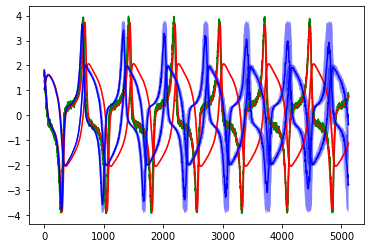

In [8]:
plt.plot(test_data[0,:,1:], 'g')

ts_depends, means_depends, stds_depends, percent_95_depends, percent_5_depends = find_ave_random_paths(t_list_list, y_pred_list_depends)
ts_original, means_original, stds_original, percent_95_original, percent_5_original = find_ave_random_paths(t_list_list, y_pred_list_original)

plt.plot(ts_depends, means_depends, 'r')
plt.plot(ts_original, means_original, 'b')

for i in [0,1]:
    plt.fill_between(ts_depends, percent_5_depends[:,i], percent_95_depends[:,i], facecolor='red', alpha=0.5)
    plt.fill_between(ts_original, percent_5_original[:,i], percent_95_original[:,i], facecolor='blue', alpha=0.5)


# for i in range(len(y_pred_list_depends)):
#     plt.plot(t_list_list[i], y_pred_list_depends[i], 'r')
#     plt.plot(t_list_list[i], y_pred_list_original[i], 'b')
    


In [ ]:
print(mse_list_depends[0].shape)
print(mse_list_depends[1].shape)

to_ave.shape =  (100, 10000)
52
0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 / 100
49 / 100
50 / 100
51 / 100
52 / 100
53 / 100
54 / 100
55 / 100
56 / 100
57 / 100
58 / 100
59 / 100
60 / 100
61 / 100
62 / 100
63 / 100
64 / 100
65 / 100
66 / 100
67 / 100
68 / 100
69 / 100
70 / 100
71 / 100
72 / 100
73 / 100
74 / 100
75 / 100
76 / 100
77 / 100
78 / 100
79 / 100
80 / 100
81 / 100
82 / 100
83 / 100
84 / 100
85 / 100
86 / 100
87 / 100
88 / 100
89 / 100
90 / 100
91 / 100
92 / 100
93 / 100
94 / 100
95 / 100
96 / 100
97 / 100
98 / 100
99 / 100
finding 50 %
finding std
finding 95 %
finding 5 %
finding mask
to_ave.shape = 

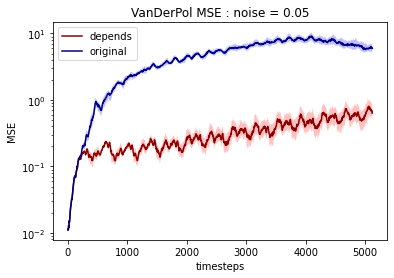

In [11]:


#start of the plotting code

# fig, axs  = plt.subplots(1, len(noise_list), sharey='row', figsize=(10, 4))

plt.figure()
    
num_lines = 100
    #find the average paths for both methods
ts_depends, means_depends, stds_depends, percent_95_depends, percent_5_depends = find_ave_random_paths_error(t_list_list, mse_list_depends)
ts_original, means_original, stds_original, percent_95_original, percent_5_original = find_ave_random_paths_error(t_list_list, mse_list_original)



plt.semilogy(ts_depends, means_depends, color='darkred', label="depends")
plt.semilogy(ts_original, means_original, color='navy', label="original")


plt.fill_between(ts_depends, percent_5_depends, percent_95_depends, facecolor='red', alpha=0.25)
plt.fill_between(ts_original, percent_5_original, percent_95_original, facecolor='blue', alpha=0.25)

plt.title(system + " MSE : noise = " + str(noise))
plt.xlabel("timesteps")
plt.ylabel("MSE")

plt.legend()

# axs[idx_noise].set_title("Noise = " + str(noise))



# axs[0].set(xlabel='Timesteps', ylabel='Error')
# fig.suptitle(system + ' MSE with increasing noise')#system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))

# plt.ylim([1e-8, 1])
# plt.show()


In [ ]:
for i in range(2):
    plt.semilogy(t_list_list[i], mse_list_depends[i])
#     plt.ylim([-0.5, 0.5])

In [ ]:
means_depends.shape

In [ ]:
 # graph the mse both themods with a random line for each trial and thicker line for average of mse
plt.figure()
plt.semilogy(ts_depends, means_depends[:,0], color='darkred', label="depends")
plt.semilogy(ts_original, means_original[:,0], color='navy', label="original")



plt.legend()
plt.title(system + ": MSE : noise = " + str(noise) + ": " + str(num_lines) + " random paths :step_sizes = "+str(step_sizes))
plt.savefig("{}_{}_min{}_MSE_both_n{}_all.jpg".format(system, letter, min(step_sizes), noise))

In [ ]:

n_timesteps = 1e10
for i in range(len(t_list_list)):
    if n_timesteps > max(t_list_list[i]):
        n_timesteps = max(t_list_list[i])
        
y_preds_all_depends = np.zeros((len(y_pred_list_depends), n_timesteps, test_data.shape[2]))
y_preds_all_original = np.zeros((len(y_pred_list_original), n_timesteps, test_data.shape[2]))
#we need to interpolate y_preds
for i in range(len(t_list_list)):
    t = np.insert(t_list_list[i], 0, 0)
    y_depends = np.insert(y_pred_list_depends[i], 0, test_data[0,0], axis = 0)
    y_original = np.insert(y_pred_list_original[i], 0, test_data[0,0], axis = 0)
    
    sample_steps = range(0, n_timesteps)
    cs_depends = scipy.interpolate.interp1d(t, y_depends.T, kind='linear')
    y_preds_depends = cs_depends(sample_steps).T
    y_preds_all_depends[i] = y_preds_depends
    
    cs_original = scipy.interpolate.interp1d(t, y_original.T, kind='linear')
    y_preds_original = cs_original(sample_steps).T
    y_preds_all_original[i] = y_preds_original


means_depends = np.mean(y_preds_all_depends, axis = 0)
stds_depends = np.std(y_preds_all_depends, axis = 0)

means_original = np.mean(y_preds_all_original, axis = 0)
stds_original = np.std(y_preds_all_original, axis = 0)

ts = sample_steps



plt.figure()
plt.plot(test_data[0,:timesteps], 'g', label = 'test_data', linewidth = 0.5)
plt.plot(ts, means_depends, 'r', label = "depends")
plt.plot(ts, means_original, 'blue', label = "original")
for i in range(len(means_depends[0])):
    for n_stds in range(1, 4):
        plt.fill_between(ts, means_depends[:,i]+n_stds*stds_depends[:,i], means_depends[:,i]-n_stds*stds_depends[:,i], facecolor='red', alpha=0.25)
        plt.fill_between(ts, means_original[:,i]+n_stds*stds_original[:,i], means_original[:,i]-n_stds*stds_original[:,i], facecolor='blue', alpha=0.25)
        
plt.legend()
plt.title(system + ": Predicted 1 path: noise = " + str(noise) +" :step_sizes = "+str(step_sizes))
plt.savefig("{}_{}_min{}_both_predict_first_shaded_n{}.jpg".format(system, letter, min(step_sizes), noise))